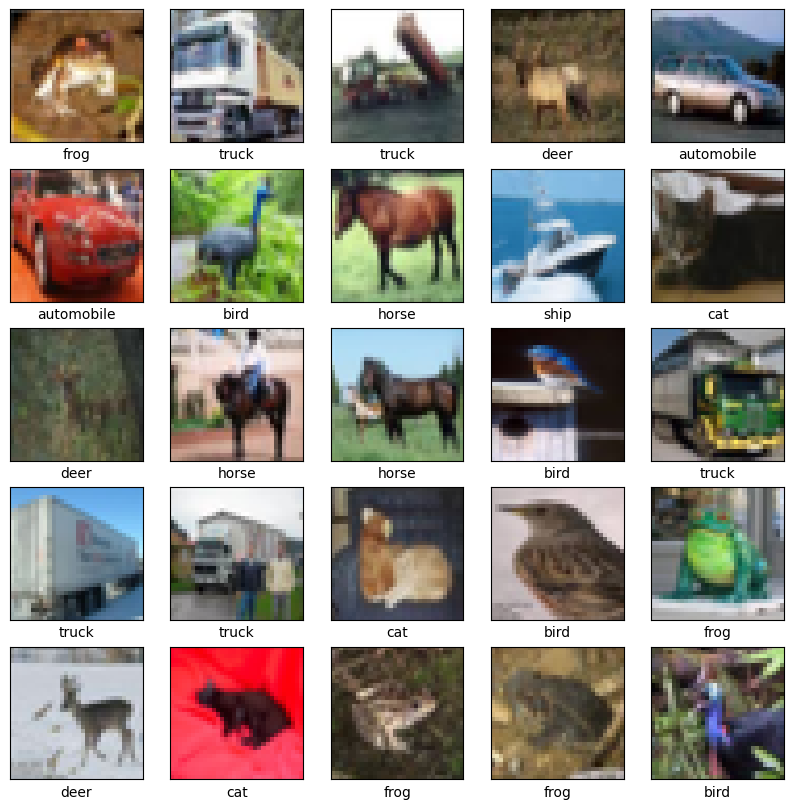

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras import datasets

# Load dataset CIFAR-10
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalisasi pixel (0-1)
train_images, test_images = train_images / 255.0, test_images / 255.0

# Nama kelas
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Tampilkan 25 gambar pertama
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()


[INFO] Dipakai 5000 gambar untuk clustering.
[INFO] Varian terjelaskan PCA (50 komponen): 0.846


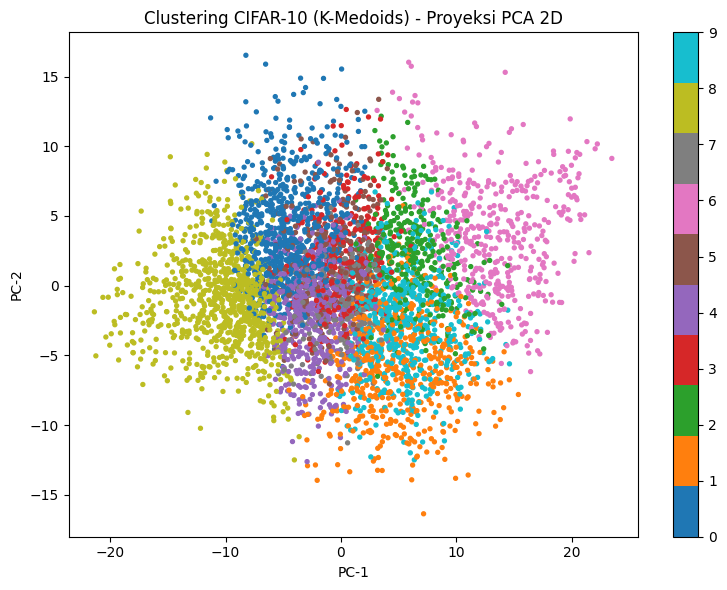

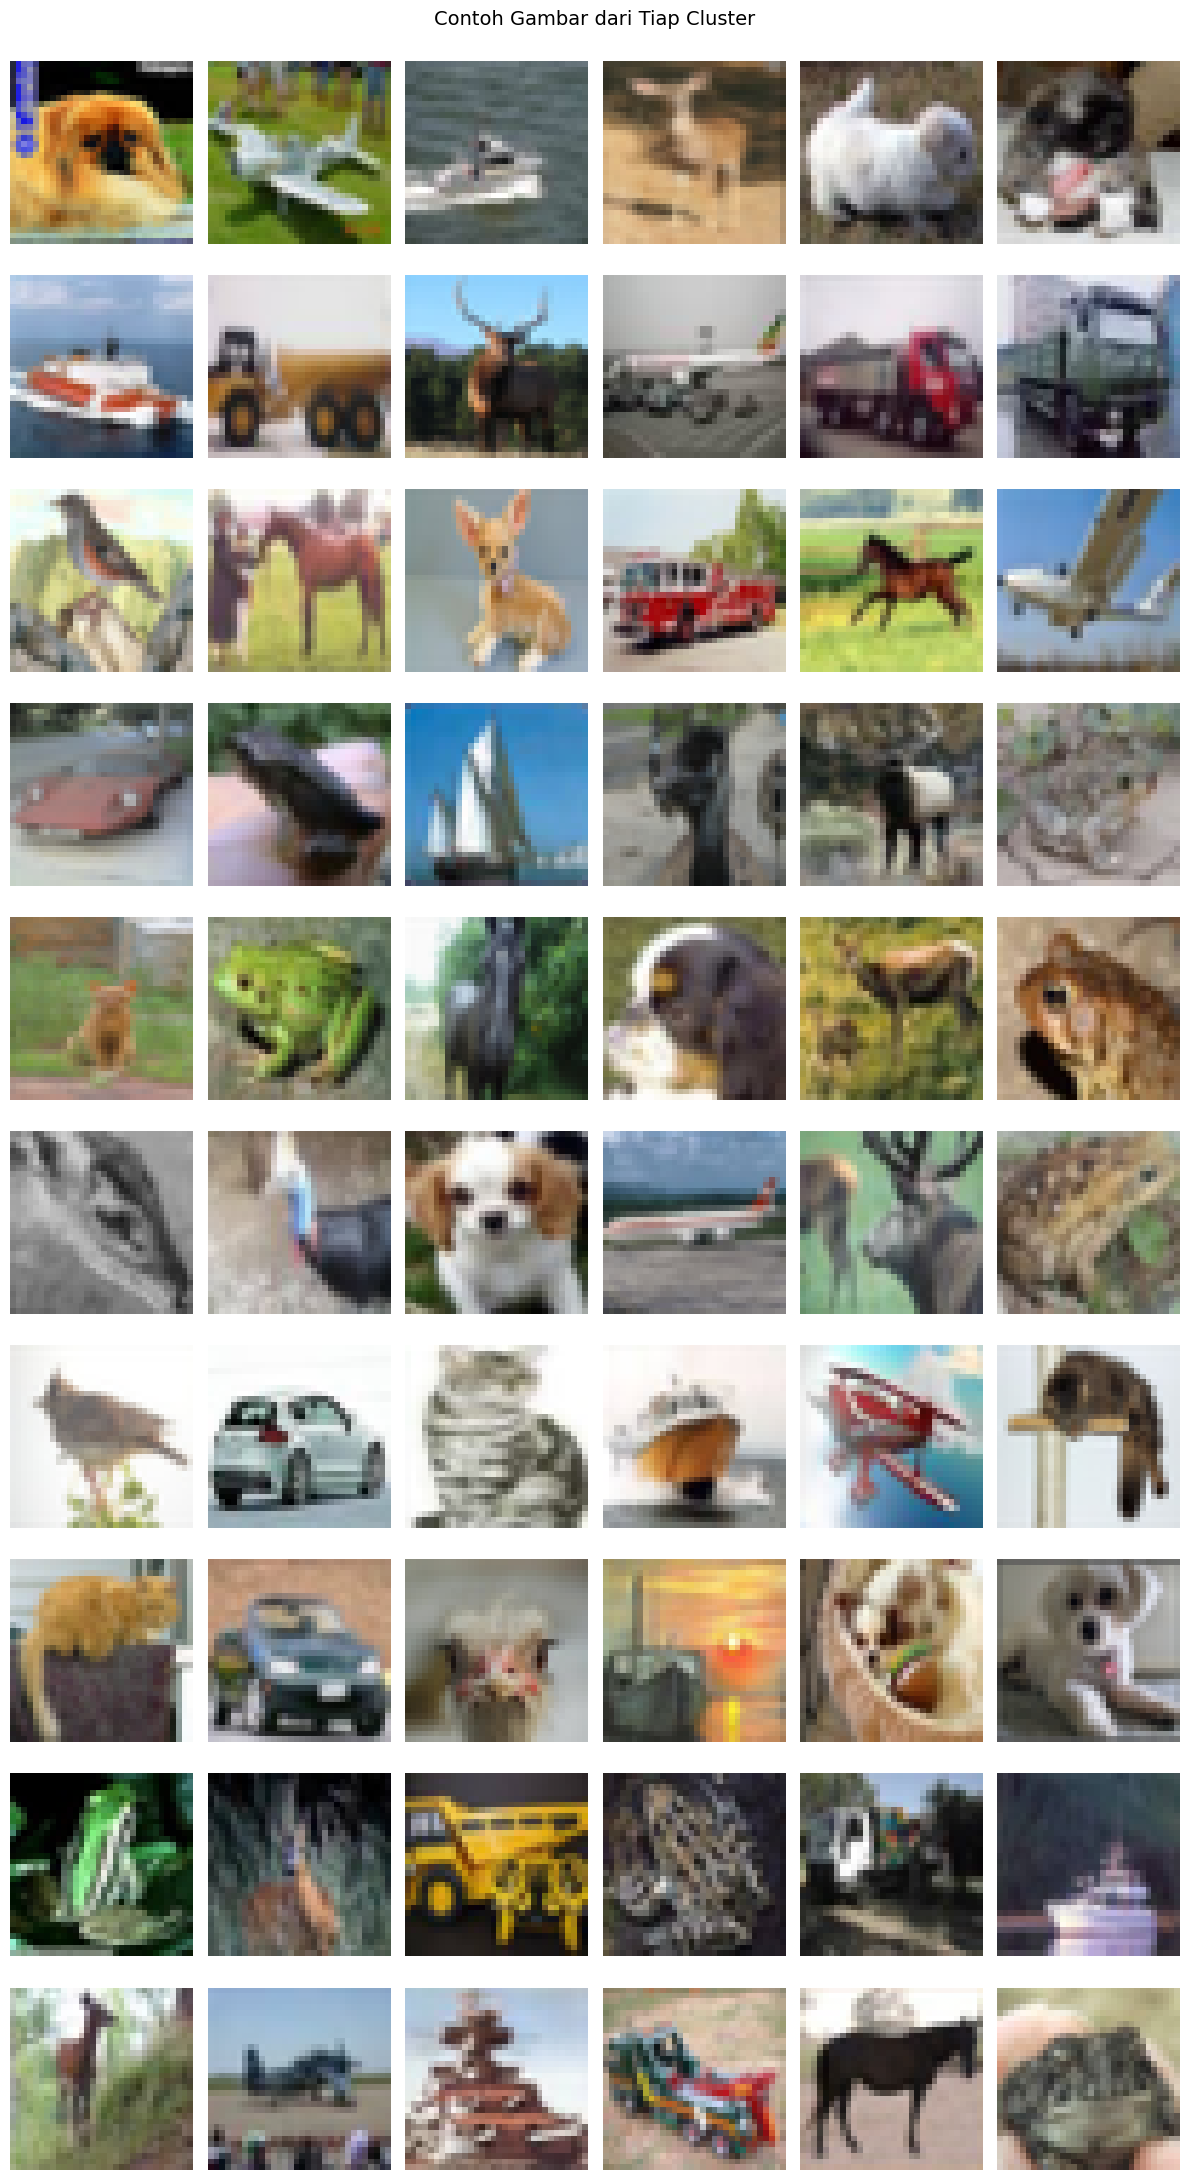


[Ringkasan jumlah item per cluster]
 - Cluster 0: 784 gambar
 - Cluster 1: 553 gambar
 - Cluster 2: 369 gambar
 - Cluster 3: 315 gambar
 - Cluster 4: 588 gambar
 - Cluster 5: 298 gambar
 - Cluster 6: 452 gambar
 - Cluster 7: 220 gambar
 - Cluster 8: 874 gambar
 - Cluster 9: 547 gambar

[Komposisi Label Asli di Tiap Cluster]
         airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck
Cluster                                                                      
0              18          71    72  104   122  142   109     98    32     16
1              93          71    19   11    14    9     1     21   188    126
2              47          19    58   39    30   36    33     33    39     35
3              42          32    34   33    40   21    29     37    21     26
4              26          59    72   47    85   48    79     70    26     76
5              18          35    17   43    24   63    13     16    53     16
6             160          23    55   38    16   

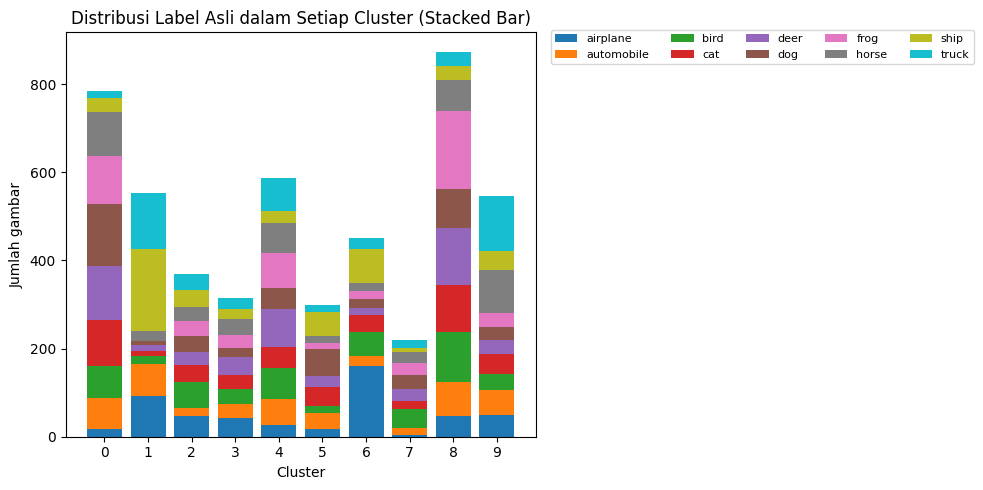

In [7]:
# ===================================================
# MODIFIKASI KLASTER CIFAR-10 (K-Medoids + PCA)
# ===================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Impor pustaka yang diperlukan
from tensorflow.keras import datasets
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids  # [MODIFIKASI] Menggunakan KMedoids

# -----------------------------
# CONFIG
# -----------------------------
N_SAMPLES       = 5000      # banyak data train yang dipakai agar ringan
PCA_COMPONENTS  = 50        # kompres fitur 3072 -> 50
N_CLUSTERS      = 10        # jumlah cluster (CIFAR-10 = 10 kelas)
SEED            = 42        # untuk reproduksibilitas
SHOW_EXAMPLES   = True      # tampilkan contoh gambar per cluster
N_EXAMPLES      = 6         # jumlah contoh per cluster saat ditampilkan

CLASS_NAMES = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# -----------------------------
# 1) Load & normalisasi data
# -----------------------------
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = train_images.astype("float32") / 255.0

# -----------------------------
# 2) Sampling agar ringan
# -----------------------------
X = train_images[:N_SAMPLES]
y = train_labels[:N_SAMPLES].flatten()

print(f"[INFO] Dipakai {len(X)} gambar untuk clustering.")

# -----------------------------
# 3) Flatten (32x32x3 -> 3072)
# -----------------------------
X_flat = X.reshape(len(X), -1)

# -----------------------------
# 4) PCA: reduksi dimensi
# -----------------------------
pca = PCA(n_components=PCA_COMPONENTS, random_state=SEED)
X_pca = pca.fit_transform(X_flat)
print(f"[INFO] Varian terjelaskan PCA ({PCA_COMPONENTS} komponen): {pca.explained_variance_ratio_.sum():.3f}")

# -----------------------------
# 5) K-Medoids clustering
# -----------------------------
# [MODIFIKASI] Mengganti KMeans dengan KMedoids.
# KMedoids tidak menggunakan parameter 'n_init'.
kmedoids = KMedoids(n_clusters=N_CLUSTERS, random_state=SEED)
clusters = kmedoids.fit_predict(X_pca)

# -----------------------------
# 6) Visualisasi 2D (PCA 2D)
# -----------------------------
pca2 = PCA(n_components=2, random_state=SEED)
X_2d = pca2.fit_transform(X_flat)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters, cmap='tab10', s=8)
plt.colorbar(scatter)
plt.title("Clustering CIFAR-10 (K-Medoids) - Proyeksi PCA 2D") # [MODIFIKASI] Judul diubah
plt.xlabel("PC-1")
plt.ylabel("PC-2")
plt.tight_layout()
plt.show()

# -----------------------------
# 7) Contoh gambar per cluster
# -----------------------------
def plot_cluster_examples(images, cluster_ids, n_clusters=N_CLUSTERS, n_examples=N_EXAMPLES):
    rng = np.random.default_rng(SEED)
    plt.figure(figsize=(n_examples*2, n_clusters*2.2))
    for c in range(n_clusters):
        idxs = np.where(cluster_ids == c)[0]
        if len(idxs) == 0:
            continue
        chosen = rng.choice(idxs, size=min(n_examples, len(idxs)), replace=False)
        for j, idx in enumerate(chosen):
            ax = plt.subplot(n_clusters, n_examples, c*n_examples + j + 1)
            ax.imshow(images[idx])
            ax.axis("off")
            if j == 0:
                ax.set_ylabel(f"Cluster {c}", fontsize=11)
    plt.suptitle("Contoh Gambar dari Tiap Cluster", fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()

if SHOW_EXAMPLES:
    plot_cluster_examples(X, clusters, n_clusters=N_CLUSTERS, n_examples=N_EXAMPLES)

# -----------------------------
# 8) Ringkasan ukuran cluster
# -----------------------------
unique, counts = np.unique(clusters, return_counts=True)
print("\n[Ringkasan jumlah item per cluster]")
for c, cnt in zip(unique, counts):
    print(f" - Cluster {c}: {cnt} gambar")

# -----------------------------
# 9) Tabel perbandingan cluster vs label asli
# -----------------------------
df_cmp = pd.DataFrame({"Cluster": clusters, "LabelAsli": y})
ct = pd.crosstab(df_cmp["Cluster"], df_cmp["LabelAsli"])
# beri nama kolom label dengan nama kelas biar mudah dibaca
ct.columns = [CLASS_NAMES[i] for i in ct.columns]
print("\n[Komposisi Label Asli di Tiap Cluster]")
print(ct)

# -----------------------------
# 10) Label dominan per cluster
# -----------------------------
print("\n[Label dominan tiap cluster]")
for c in range(N_CLUSTERS):
    labels_in_c = y[clusters == c]
    if len(labels_in_c) == 0:
        print(f" - Cluster {c}: (kosong)")
        continue
    common_label, freq = Counter(labels_in_c).most_common(1)[0]
    p = freq / len(labels_in_c)
    print(f" - Cluster {c}: dominan '{CLASS_NAMES[common_label]}' ({freq} dari {len(labels_in_c)} = {p:.1%})")

# -----------------------------
# 11) (Opsional) Visual ringkas distribusi label per cluster
#     (tanpa seaborn, pakai stacked bar sederhana)
# -----------------------------
plt.figure(figsize=(10,5))
cluster_order = sorted(unique)
bottom = np.zeros(len(cluster_order))
colors = plt.cm.tab10.colors

for lbl_idx, lbl_name in enumerate(CLASS_NAMES):
    vals = ct[lbl_name].reindex(cluster_order, fill_value=0).values
    plt.bar(cluster_order, vals, bottom=bottom, label=lbl_name, color=colors[lbl_idx%10])
    bottom += vals

plt.xticks(cluster_order)
plt.xlabel("Cluster")
plt.ylabel("Jumlah gambar")
plt.title("Distribusi Label Asli dalam Setiap Cluster (Stacked Bar)")
plt.legend(ncol=5, fontsize=8, bbox_to_anchor=(1.02, 1.02), loc="upper left")
plt.tight_layout()
plt.show()

[INFO] Dipakai 5000 gambar untuk K-Medoids.
[INFO] Varian terjelaskan PCA(50): 0.846

[EVALUASI K-MEDOIDS]
 - Silhouette Score : 0.0464
 - Adjusted Rand (ARI): 0.0374
 - Normalized MI (NMI): 0.0805
 - Jumlah item/cluster: {0: 810, 1: 592, 2: 519, 3: 501, 4: 326, 5: 296, 6: 411, 7: 332, 8: 582, 9: 631}

[Komposisi Label Asli per Cluster]
         airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck
Cluster                                                                      
0              30          73    98  104   112  137   107     84    36     29
1              71          90    38   23    24   27    17     47   123    132
2              28          38    47   67    67   59    73     78    17     45
3              32          42    55   71    64   51   113     33    20     20
4               3          28    19   52    68   67    33     35    17      4
5              27          36     6    8    15    8     2     50    42    102
6             141           9    71  

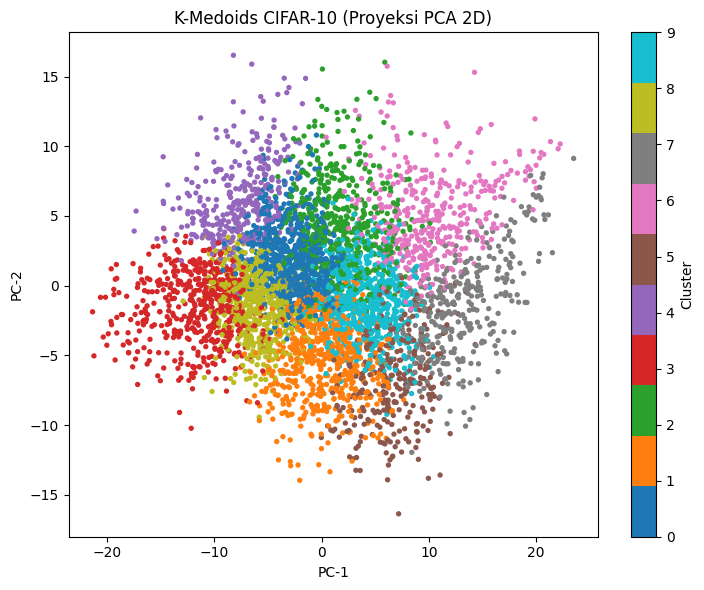

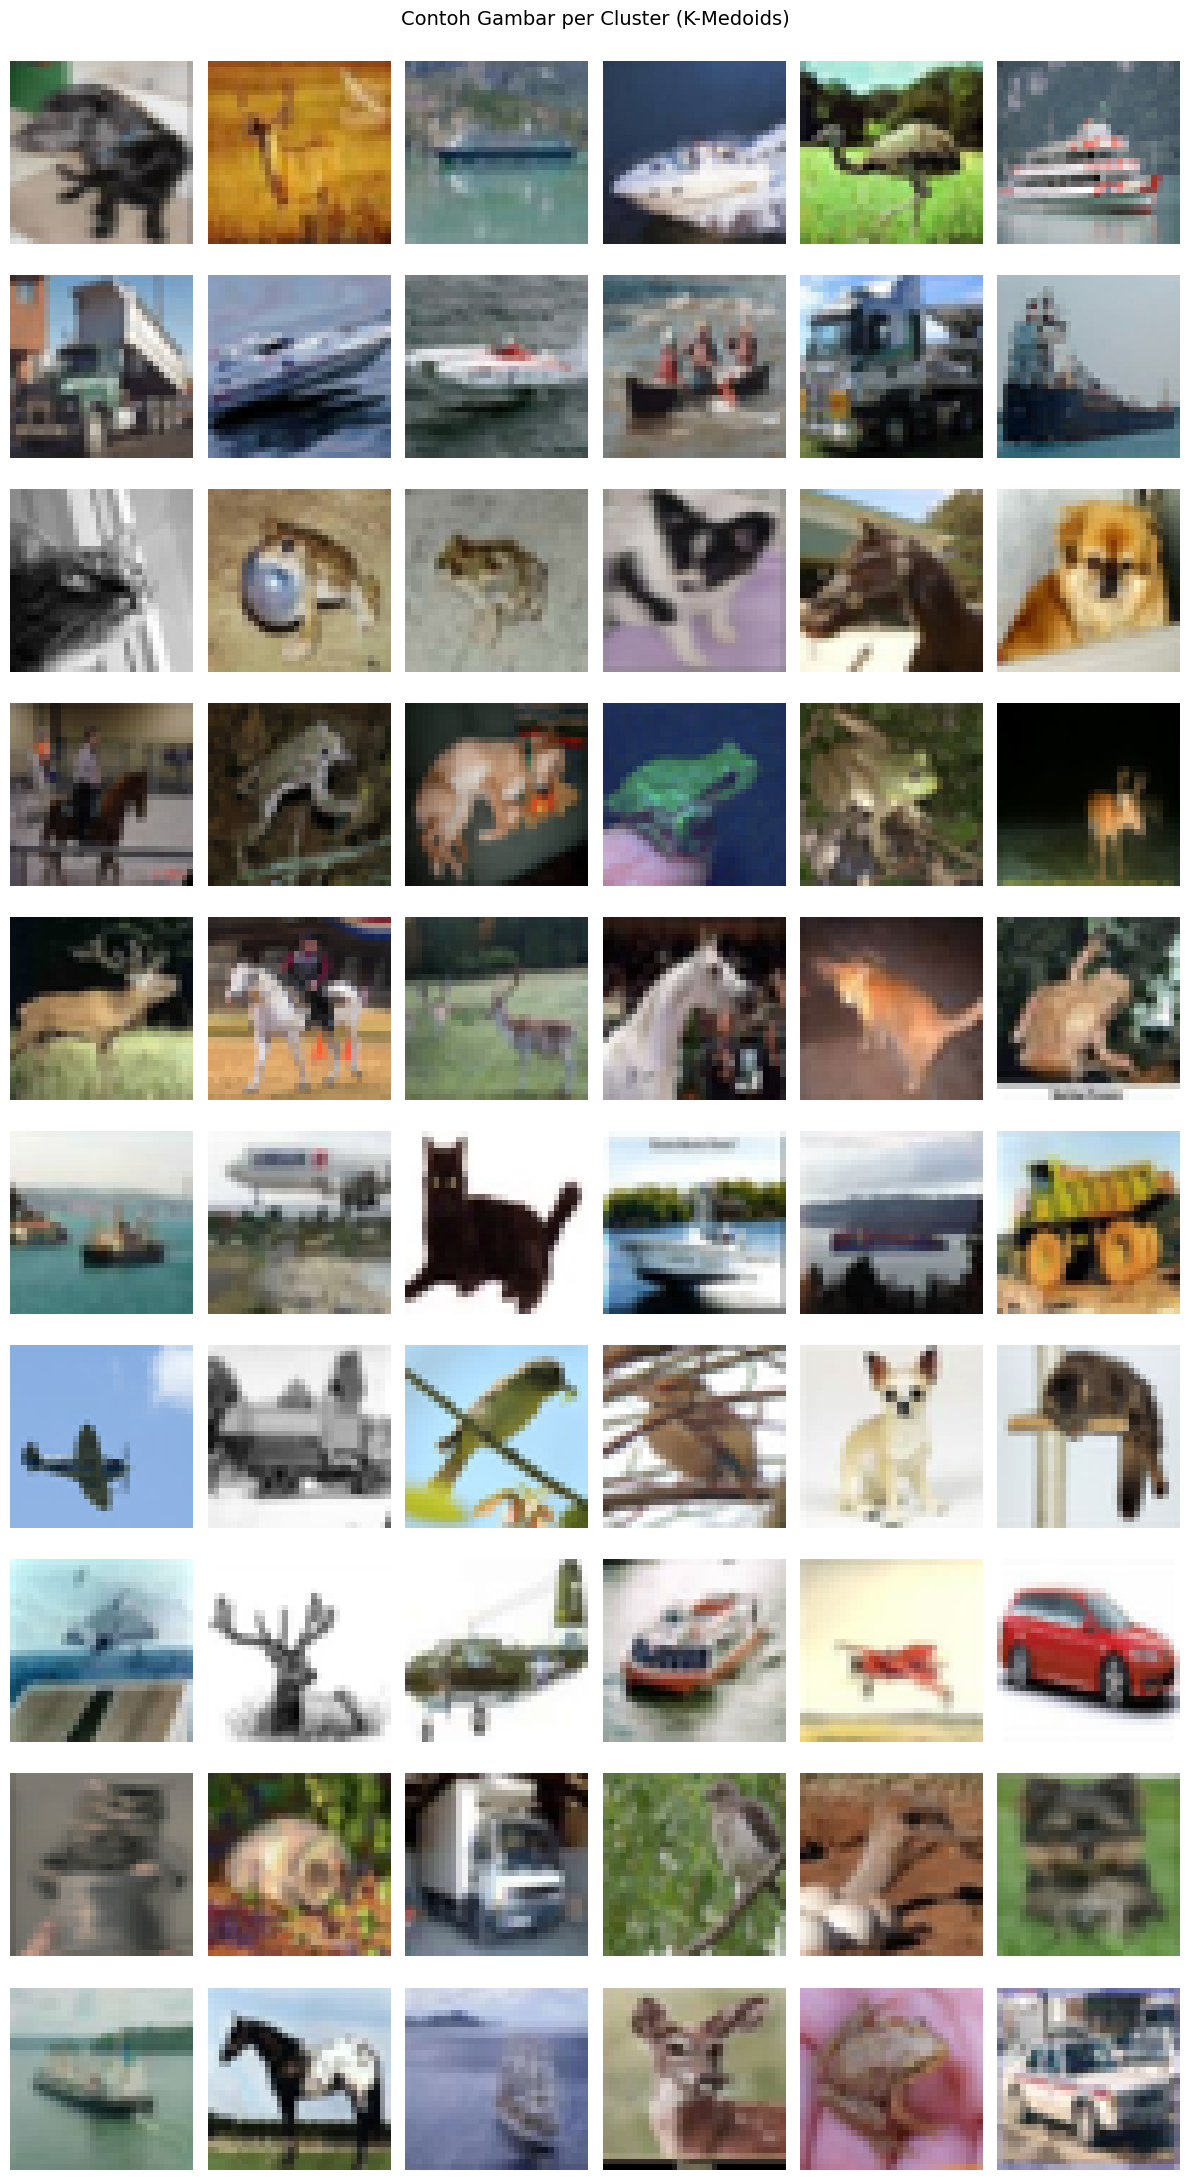


[Medoid] Indeks gambar pusat tiap cluster: [3684, 1092, 254, 2650, 4108, 4053, 2034, 284, 1838, 1759]


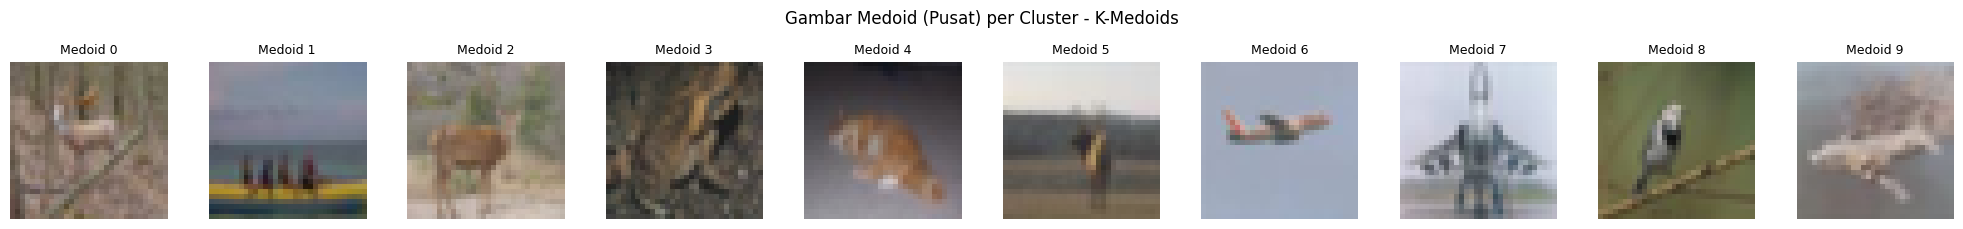

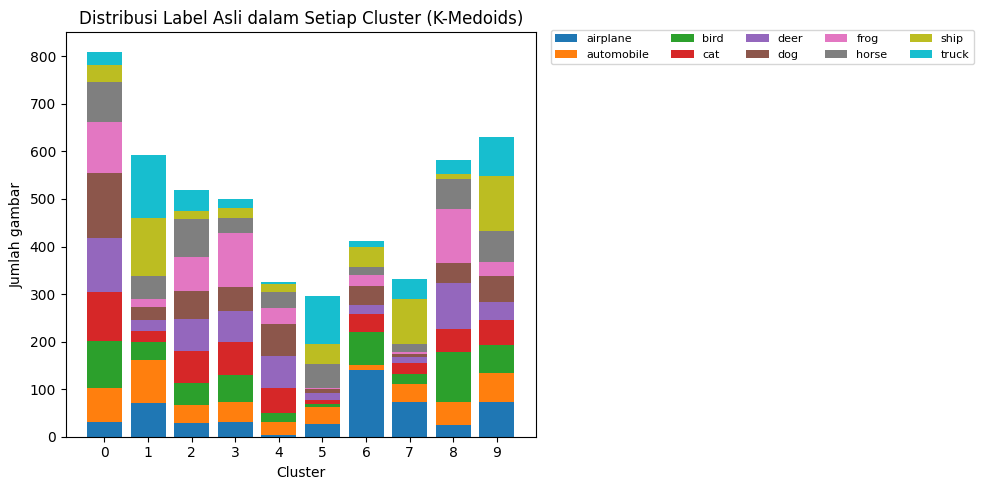

In [8]:
# ================================================
# KLASTERING K-MEDOIDS CIFAR-10 (ONLY) + EVALUASI
# ================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

from tensorflow.keras import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn_extra.cluster import KMedoids

# -----------------------------
# KONFIGURASI
# -----------------------------
N_SAMPLES      = 5000     # gunakan subset agar ringan
PCA_COMPONENTS = 50       # reduksi dimensi 3072 -> 50
N_CLUSTERS     = 10       # CIFAR-10: 10 kelas
SEED           = 42
SHOW_IMAGES    = True     # tampilkan contoh gambar per cluster
N_EXAMPLES     = 6

CLASS_NAMES = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# -----------------------------
# 1) LOAD DATA & NORMALISASI
# -----------------------------
(train_images, train_labels), _ = datasets.cifar10.load_data()
train_images = train_images.astype("float32") / 255.0
X = train_images[:N_SAMPLES]
y = train_labels[:N_SAMPLES].flatten()
print(f"[INFO] Dipakai {len(X)} gambar untuk K-Medoids.")

# -----------------------------
# 2) FLATTEN & PCA (50D)
# -----------------------------
X_flat = X.reshape(len(X), -1)
pca = PCA(n_components=PCA_COMPONENTS, random_state=SEED)
X_pca = pca.fit_transform(X_flat)
print(f"[INFO] Varian terjelaskan PCA({PCA_COMPONENTS}): {pca.explained_variance_ratio_.sum():.3f}")

# -----------------------------
# 3) K-MEDOIDS CLUSTERING
# -----------------------------
kmedoids = KMedoids(
    n_clusters=N_CLUSTERS,
    random_state=SEED,
    method="pam",
    metric="euclidean"
)
clusters = kmedoids.fit_predict(X_pca)
medoid_indices = kmedoids.medoid_indices_

# -----------------------------
# 4) METRIK EVALUASI
#    - Silhouette  : kualitas cluster (0..1 lebih tinggi lebih baik)
#    - ARI         : kesesuaian cluster vs label asli (-1..1)
#    - NMI         : kesesuaian (0..1)
# -----------------------------
sil = silhouette_score(X_pca, clusters)
ari = adjusted_rand_score(y, clusters)
nmi = normalized_mutual_info_score(y, clusters)

print("\n[EVALUASI K-MEDOIDS]")
print(f" - Silhouette Score : {sil:.4f}")
print(f" - Adjusted Rand (ARI): {ari:.4f}")
print(f" - Normalized MI (NMI): {nmi:.4f}")

# Ringkasan ukuran cluster
uniq, cnts = np.unique(clusters, return_counts=True)
print(" - Jumlah item/cluster:", dict(zip(uniq, cnts)))

# Komposisi label asli per cluster (crosstab)
df_cmp = pd.DataFrame({"Cluster": clusters, "LabelAsli": y})
ct = pd.crosstab(df_cmp["Cluster"], df_cmp["LabelAsli"])
ct.columns = [CLASS_NAMES[i] for i in ct.columns]
print("\n[Komposisi Label Asli per Cluster]")
print(ct)

# Label dominan tiap cluster
print("\n[Label dominan per cluster]")
for c in range(N_CLUSTERS):
    labels_in_c = y[clusters == c]
    if len(labels_in_c) == 0:
        print(f" - Cluster {c}: (kosong)")
        continue
    lab, freq = Counter(labels_in_c).most_common(1)[0]
    p = freq / len(labels_in_c)
    print(f" - Cluster {c}: dominan '{CLASS_NAMES[lab]}' ({freq}/{len(labels_in_c)} = {p:.1%})")

# -----------------------------
# 5) VISUALISASI 2D (PCA -> 2D)
# -----------------------------
pca2 = PCA(n_components=2, random_state=SEED)
X_2d = pca2.fit_transform(X_flat)

plt.figure(figsize=(7.5,6))
sc = plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters, cmap='tab10', s=8)
plt.colorbar(sc, label="Cluster")
plt.title("K-Medoids CIFAR-10 (Proyeksi PCA 2D)")
plt.xlabel("PC-1"); plt.ylabel("PC-2")
plt.tight_layout()
plt.show()

# -----------------------------
# 6) CONTOH GAMBAR PER CLUSTER
# -----------------------------
def plot_cluster_examples(images, cluster_ids, n_clusters=N_CLUSTERS, n_examples=N_EXAMPLES, title="Contoh Gambar per Cluster (K-Medoids)"):
    rng = np.random.default_rng(SEED)
    plt.figure(figsize=(n_examples*2, n_clusters*2.2))
    for c in range(n_clusters):
        idxs = np.where(cluster_ids == c)[0]
        if len(idxs) == 0:
            continue
        chosen = rng.choice(idxs, size=min(n_examples, len(idxs)), replace=False)
        for j, idx in enumerate(chosen):
            ax = plt.subplot(n_clusters, n_examples, c*n_examples + j + 1)
            ax.imshow(images[idx])
            ax.axis("off")
            if j == 0:
                ax.set_ylabel(f"Cluster {c}", fontsize=11)
    plt.suptitle(title, fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()

if SHOW_IMAGES:
    plot_cluster_examples(X, clusters)

# -----------------------------
# 7) TAMPILKAN MEDOID (PUSAT ASLI)
# -----------------------------
print("\n[Medoid] Indeks gambar pusat tiap cluster:", medoid_indices.tolist())

plt.figure(figsize=(N_CLUSTERS*2, 2.2))
for i, idx in enumerate(medoid_indices):
    ax = plt.subplot(1, N_CLUSTERS, i+1)
    ax.imshow(X[idx])
    ax.set_title(f"Medoid {i}", fontsize=9)
    ax.axis("off")
plt.suptitle("Gambar Medoid (Pusat) per Cluster - K-Medoids", y=1.02)
plt.tight_layout()
plt.show()

# -----------------------------
# 8) GRAFIK STACKED BAR (label asli per cluster)
# -----------------------------
plt.figure(figsize=(10,5))
order = sorted(uniq)
bottom = np.zeros(len(order))
colors = plt.cm.tab10.colors

for lbl_idx, lbl_name in enumerate(CLASS_NAMES):
    vals = ct[lbl_name].reindex(order, fill_value=0).values
    plt.bar(order, vals, bottom=bottom, label=lbl_name, color=colors[lbl_idx%10])
    bottom += vals

plt.xticks(order)
plt.xlabel("Cluster")
plt.ylabel("Jumlah gambar")
plt.title("Distribusi Label Asli dalam Setiap Cluster (K-Medoids)")
plt.legend(ncol=5, fontsize=8, bbox_to_anchor=(1.02, 1.02), loc="upper left")
plt.tight_layout()
plt.show()
# -----------------------------
# 9) (Opsional) Visual ringkas distribusi label per cluster

[INFO] Dipakai 5000 gambar untuk K-Medoids.
[INFO] Varian terjelaskan PCA(50): 0.846

[INFO] Mulai pengujian K-Medoids untuk K dari 5 hingga 15...
 - K=5: Silhouette=0.0858, ARI=0.0393, NMI=0.0760
 - K=6: Silhouette=0.0770, ARI=0.0415, NMI=0.0766
 - K=7: Silhouette=0.0698, ARI=0.0377, NMI=0.0805
 - K=8: Silhouette=0.0677, ARI=0.0382, NMI=0.0832
 - K=9: Silhouette=0.0523, ARI=0.0438, NMI=0.0884
 - K=10: Silhouette=0.0464, ARI=0.0374, NMI=0.0805
 - K=11: Silhouette=0.0484, ARI=0.0383, NMI=0.0833
 - K=12: Silhouette=0.0489, ARI=0.0392, NMI=0.0861
 - K=13: Silhouette=0.0412, ARI=0.0389, NMI=0.0866
 - K=14: Silhouette=0.0424, ARI=0.0384, NMI=0.0891
 - K=15: Silhouette=0.0383, ARI=0.0375, NMI=0.0873


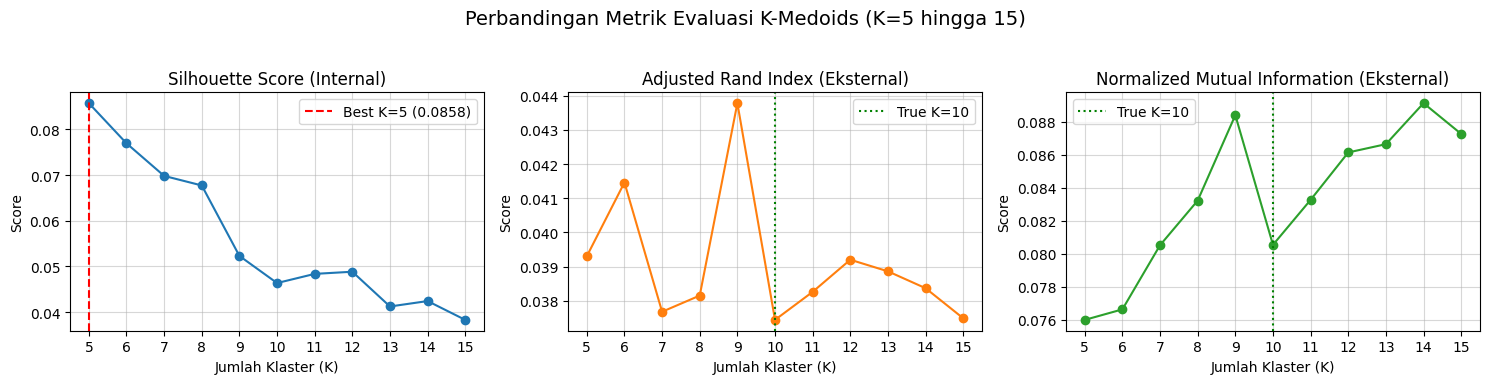


HASIL TERBAIK BERDASARKAN SILHOUETTE SCORE:
Optimal K: 5
Silhouette Score: 0.0858
ARI Score: 0.0393
NMI Score: 0.0760


In [9]:
# ========================================================
# KLASTERING K-MEDOIDS CIFAR-10: MODIFIKASI & PERBANDINGAN
# ========================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import warnings

from tensorflow.keras import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn_extra.cluster import KMedoids

# Abaikan peringatan yang umum muncul saat klastering dengan K-Medoids
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# -----------------------------
# KONFIGURASI (Sama seperti sebelumnya)
# -----------------------------
N_SAMPLES      = 5000     # gunakan subset agar ringan
PCA_COMPONENTS = 50       # reduksi dimensi 3072 -> 50
SEED           = 42
K_RANGE        = range(5, 16) # MODIFIKASI: Rentang K yang akan diuji (dari 5 sampai 15)

CLASS_NAMES = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# -----------------------------
# 1) LOAD DATA & NORMALISASI (Sama seperti sebelumnya)
# -----------------------------
(train_images, train_labels), _ = datasets.cifar10.load_data()
train_images = train_images.astype("float32") / 255.0
X = train_images[:N_SAMPLES]
y = train_labels[:N_SAMPLES].flatten()
print(f"[INFO] Dipakai {len(X)} gambar untuk K-Medoids.")

# -----------------------------
# 2) FLATTEN & PCA (50D) (Sama seperti sebelumnya)
# -----------------------------
X_flat = X.reshape(len(X), -1)
pca = PCA(n_components=PCA_COMPONENTS, random_state=SEED)
X_pca = pca.fit_transform(X_flat)
print(f"[INFO] Varian terjelaskan PCA({PCA_COMPONENTS}): {pca.explained_variance_ratio_.sum():.3f}")

# =================================================
# 3) MODIFIKASI: UJI K-MEDOIDS DENGAN BERBAGAI NILAI K
# =================================================
print("\n[INFO] Mulai pengujian K-Medoids untuk K dari 5 hingga 15...")

results = []
best_sil_score = -1
best_k = -1
best_clusters = None

for k in K_RANGE:
    kmedoids = KMedoids(
        n_clusters=k,
        random_state=SEED,
        method="pam",
        metric="euclidean"
    )
    # Latih dan prediksi klaster
    clusters = kmedoids.fit_predict(X_pca)

    # 4) METRIK EVALUASI
    sil = silhouette_score(X_pca, clusters)
    ari = adjusted_rand_score(y, clusters)
    nmi = normalized_mutual_info_score(y, clusters)

    results.append({
        'K': k,
        'Silhouette': sil,
        'ARI': ari,
        'NMI': nmi
    })

    print(f" - K={k}: Silhouette={sil:.4f}, ARI={ari:.4f}, NMI={nmi:.4f}")

    # Simpan hasil klastering terbaik berdasarkan Silhouette Score
    if sil > best_sil_score:
        best_sil_score = sil
        best_k = k
        best_clusters = clusters

df_results = pd.DataFrame(results)

# ------------------------------------------------------------------
# 5) VISUALISASI PERBANDINGAN METRIK UNTUK BERBAGAI NILAI K
# ------------------------------------------------------------------
plt.figure(figsize=(15, 4))
plt.suptitle("Perbandingan Metrik Evaluasi K-Medoids (K=5 hingga 15)", fontsize=14)

# Plot Silhouette Score
plt.subplot(1, 3, 1)
plt.plot(df_results['K'], df_results['Silhouette'], marker='o', color='tab:blue')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best K={best_k} ({best_sil_score:.4f})')
plt.title("Silhouette Score (Internal)")
plt.xlabel("Jumlah Klaster (K)")
plt.ylabel("Score")
plt.xticks(K_RANGE)
plt.legend()
plt.grid(True, alpha=0.5)

# Plot ARI (Adjusted Rand Index)
plt.subplot(1, 3, 2)
plt.plot(df_results['K'], df_results['ARI'], marker='o', color='tab:orange')
plt.axvline(x=10, color='green', linestyle=':', label='True K=10')
plt.title("Adjusted Rand Index (Eksternal)")
plt.xlabel("Jumlah Klaster (K)")
plt.ylabel("Score")
plt.xticks(K_RANGE)
plt.legend()
plt.grid(True, alpha=0.5)

# Plot NMI (Normalized Mutual Information)
plt.subplot(1, 3, 3)
plt.plot(df_results['K'], df_results['NMI'], marker='o', color='tab:green')
plt.axvline(x=10, color='green', linestyle=':', label='True K=10')
plt.title("Normalized Mutual Information (Eksternal)")
plt.xlabel("Jumlah Klaster (K)")
plt.ylabel("Score")
plt.xticks(K_RANGE)
plt.legend()
plt.grid(True, alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ------------------------------------------------------------------
# 6) RINGKASAN HASIL TERBAIK
# ------------------------------------------------------------------
print("\n" + "="*40)
print(f"HASIL TERBAIK BERDASARKAN SILHOUETTE SCORE:")
print(f"Optimal K: {best_k}")
print(f"Silhouette Score: {best_sil_score:.4f}")
print(f"ARI Score: {df_results[df_results['K'] == best_k]['ARI'].iloc[0]:.4f}")
print(f"NMI Score: {df_results[df_results['K'] == best_k]['NMI'].iloc[0]:.4f}")
print("="*40)

# Catatan: Untuk visualisasi cluster 2D, contoh gambar, dan medoid
# Anda dapat menggunakan 'best_clusters' dan 'best_k' untuk menghasilkan plot yang sama
# seperti yang ada di kode awal, tetapi hanya untuk K yang terpilih.
# Misalnya:
# N_CLUSTERS = best_k
# clusters = best_clusters
# ... dan jalankan sisa kode visualisasi dari skrip asli.

[INFO] Dipakai 5000 gambar untuk K-Medoids.
[INFO] Varian terjelaskan PCA(50): 0.846

[INFO] Uji K-Medoids untuk beberapa K...
 - K= 5: Silhouette=0.0858, ARI=0.0393, NMI=0.0760
 - K= 6: Silhouette=0.0770, ARI=0.0415, NMI=0.0766
 - K= 7: Silhouette=0.0698, ARI=0.0377, NMI=0.0805
 - K= 8: Silhouette=0.0677, ARI=0.0382, NMI=0.0832
 - K= 9: Silhouette=0.0523, ARI=0.0438, NMI=0.0884
 - K=10: Silhouette=0.0464, ARI=0.0374, NMI=0.0805
 - K=11: Silhouette=0.0484, ARI=0.0383, NMI=0.0833
 - K=12: Silhouette=0.0489, ARI=0.0392, NMI=0.0861
 - K=13: Silhouette=0.0412, ARI=0.0389, NMI=0.0866
 - K=14: Silhouette=0.0424, ARI=0.0384, NMI=0.0891
 - K=15: Silhouette=0.0383, ARI=0.0375, NMI=0.0873


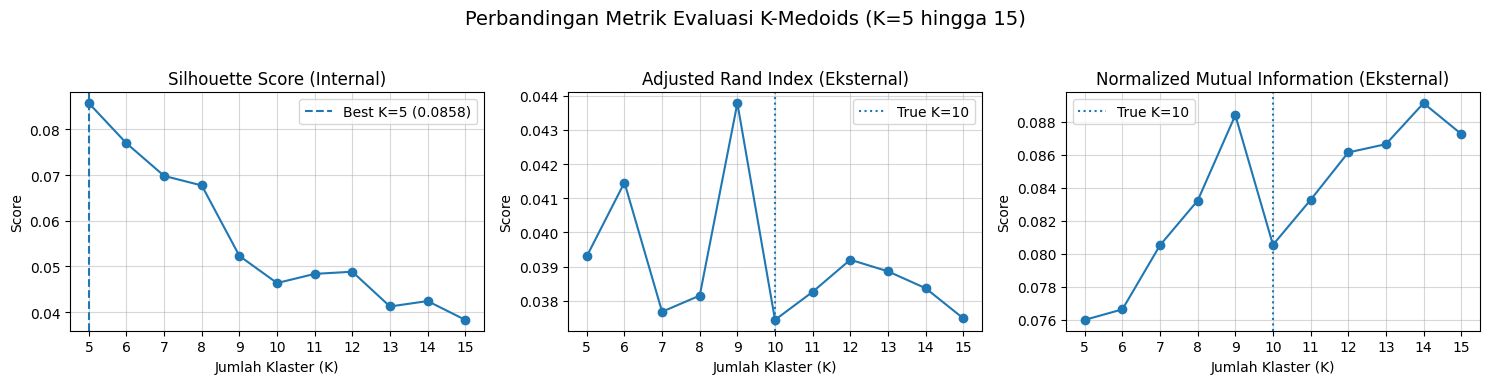


[RINGKASAN PERBANDINGAN] K terbaik (Silhouette): K=5 (score=0.0858)

[DEEP DIVE] K=5
 - Silhouette : 0.0858
 - ARI        : 0.0393
 - NMI        : 0.0760
 - Jumlah item/cluster: {0: 1477, 1: 801, 2: 868, 3: 560, 4: 1294}

[Komposisi Label Asli per Cluster]
         airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck
Cluster                                                                      
0              74         156   177  148   193  173   168    176    92    120
1              88          45   101  101    71  102    79    101    53     60
2             100         104    31   27    38   24     8     89   222    225
3             183          36    62   45    22   21    18     21   110     42
4              60         119   148  165   195  168   246     99    43     51

[Label dominan per cluster]
 - Cluster 0: dominan 'deer' (193/1477 = 13.1%)
 - Cluster 1: dominan 'dog' (102/801 = 12.7%)
 - Cluster 2: dominan 'truck' (225/868 = 25.9%)
 - Cluster 3: dominan 'ai

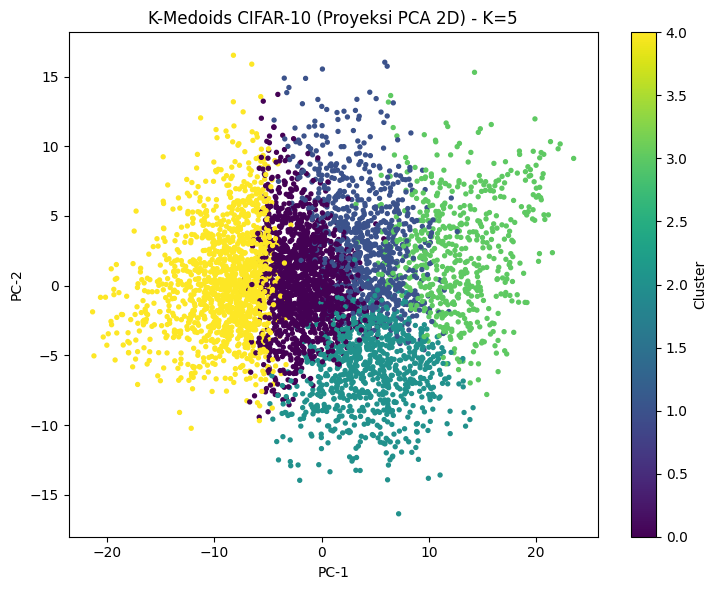

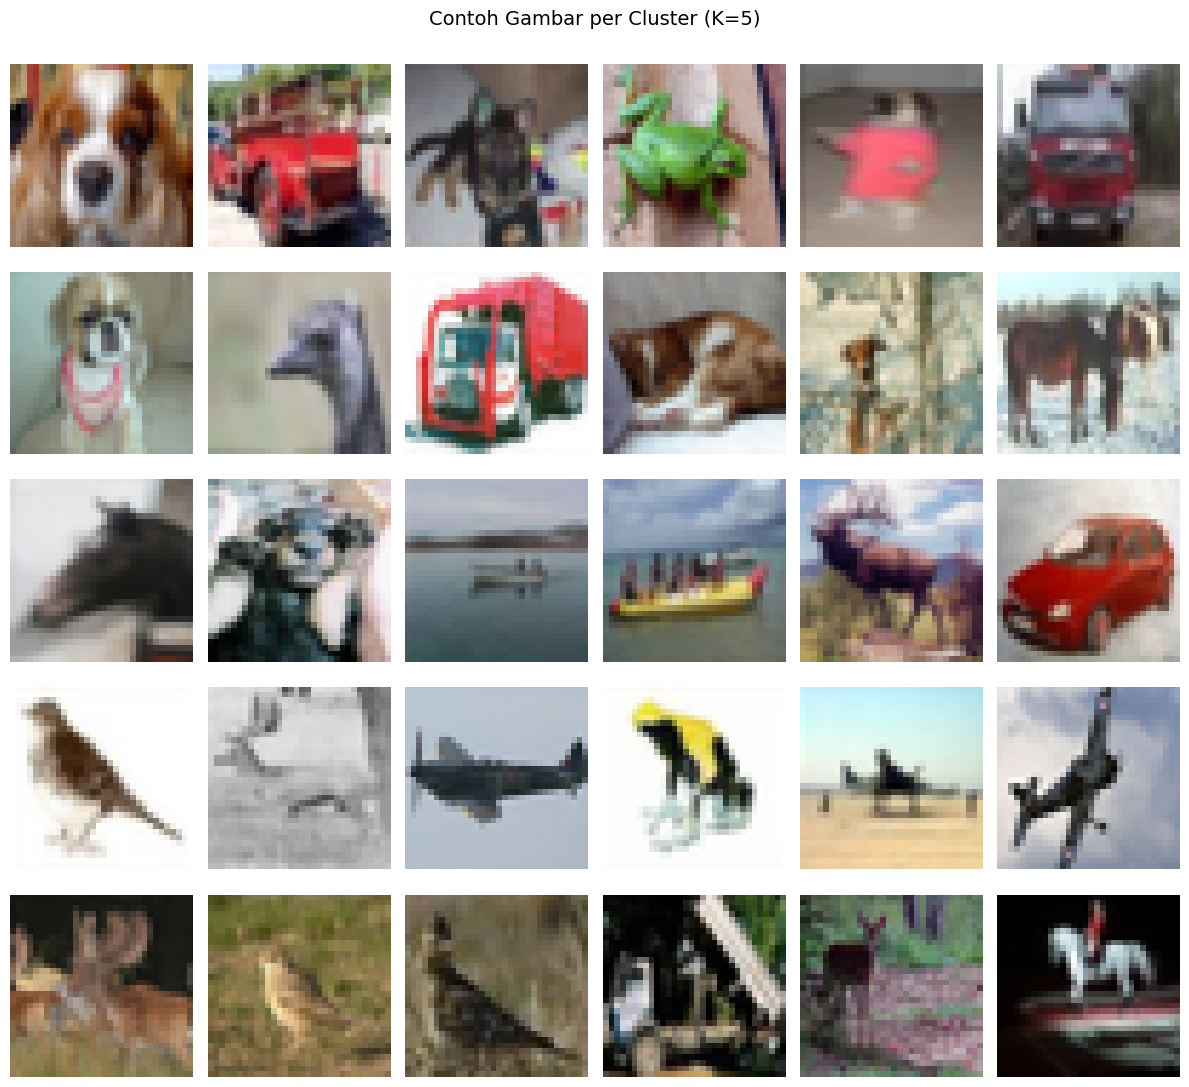


[Medoid] Indeks gambar pusat tiap cluster: [4224, 3376, 909, 2341, 2836]


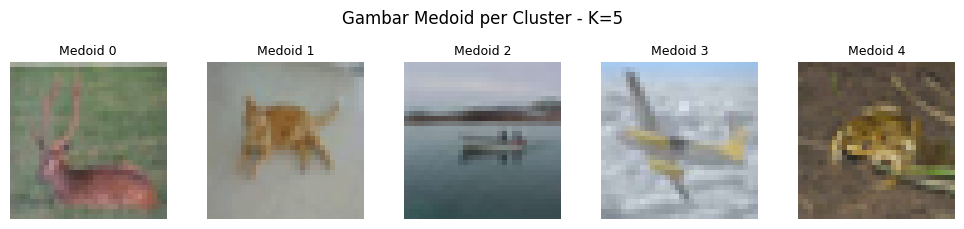

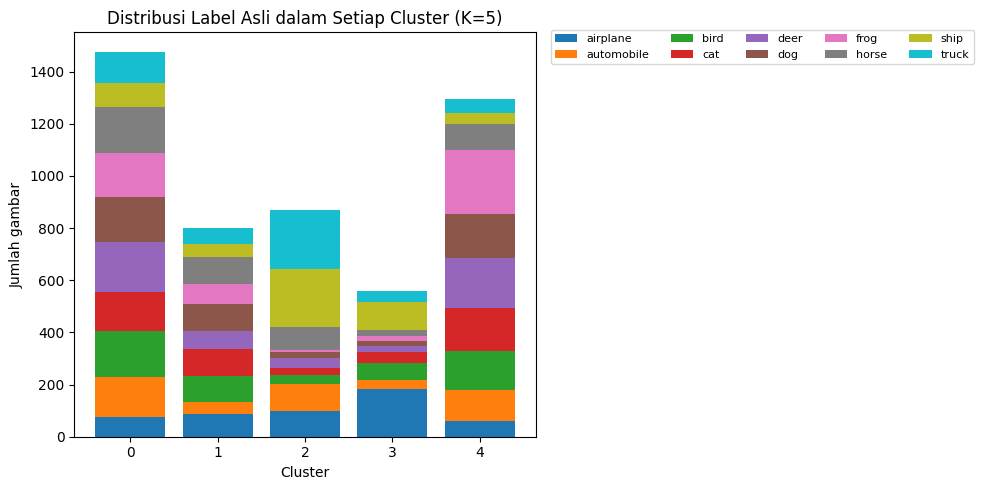

In [1]:
# ==============================================================
# K-MEDOIDS CIFAR-10: PERBANDINGAN (multi-K) + PENJELASAN (K terbaik)
# ==============================================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import warnings

from tensorflow.keras import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn_extra.cluster import KMedoids

# -----------------------------
# KONFIGURASI
# -----------------------------
N_SAMPLES       = 5000      # subset biar ringan
PCA_COMPONENTS  = 50        # reduksi 3072 -> 50
SEED            = 42
K_RANGE         = range(5, 16)  # uji K=5..15
SHOW_IMAGES     = True      # tampilkan contoh gambar per klaster
N_EXAMPLES      = 6         # contoh gambar/klaster
DEEP_DIVE_TOP_K = 1         # berapa banyak K terbaik (berdasarkan silhouette) untuk didalami; default 1

CLASS_NAMES = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# Abaikan peringatan yang umum saat klastering
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# -----------------------------
# 1) LOAD DATA & NORMALISASI
# -----------------------------
(train_images, train_labels), _ = datasets.cifar10.load_data()
train_images = train_images.astype("float32") / 255.0
X = train_images[:N_SAMPLES]
y = train_labels[:N_SAMPLES].flatten()
print(f"[INFO] Dipakai {len(X)} gambar untuk K-Medoids.")

# -----------------------------
# 2) FLATTEN & PCA (50D)
# -----------------------------
X_flat = X.reshape(len(X), -1)
pca50 = PCA(n_components=PCA_COMPONENTS, random_state=SEED)
X_pca = pca50.fit_transform(X_flat)
print(f"[INFO] Varian terjelaskan PCA({PCA_COMPONENTS}): {pca50.explained_variance_ratio_.sum():.3f}")

# =================================================
# 3) PERBANDINGAN K: LATIH K-MEDOIDS untuk K=5..15
# =================================================
print("\n[INFO] Uji K-Medoids untuk beberapa K...")
results = []
models_by_k = {}   # simpan model & clusters supaya bisa didalami nanti

for k in K_RANGE:
    model = KMedoids(n_clusters=k, random_state=SEED, method="pam", metric="euclidean")
    clusters = model.fit_predict(X_pca)

    sil = silhouette_score(X_pca, clusters)
    ari = adjusted_rand_score(y, clusters)
    nmi = normalized_mutual_info_score(y, clusters)

    results.append({'K': k, 'Silhouette': sil, 'ARI': ari, 'NMI': nmi})
    models_by_k[k] = {'model': model, 'clusters': clusters}

    print(f" - K={k:>2}: Silhouette={sil:.4f}, ARI={ari:.4f}, NMI={nmi:.4f}")

df_results = pd.DataFrame(results)

# -----------------------------
# 4) VISUALISASI PERBANDINGAN METRIK
# -----------------------------
best_row = df_results.loc[df_results['Silhouette'].idxmax()]
best_k = int(best_row['K'])
best_sil = float(best_row['Silhouette'])

plt.figure(figsize=(15, 4))
plt.suptitle("Perbandingan Metrik Evaluasi K-Medoids (K=5 hingga 15)", fontsize=14)

# Silhouette
plt.subplot(1, 3, 1)
plt.plot(df_results['K'], df_results['Silhouette'], marker='o')
plt.axvline(x=best_k, linestyle='--', label=f'Best K={best_k} ({best_sil:.4f})')
plt.title("Silhouette Score (Internal)")
plt.xlabel("Jumlah Klaster (K)")
plt.ylabel("Score")
plt.xticks(list(K_RANGE))
plt.legend()
plt.grid(True, alpha=0.5)

# ARI
plt.subplot(1, 3, 2)
plt.plot(df_results['K'], df_results['ARI'], marker='o')
plt.axvline(x=10, linestyle=':', label='True K=10')
plt.title("Adjusted Rand Index (Eksternal)")
plt.xlabel("Jumlah Klaster (K)")
plt.ylabel("Score")
plt.xticks(list(K_RANGE))
plt.legend()
plt.grid(True, alpha=0.5)

# NMI
plt.subplot(1, 3, 3)
plt.plot(df_results['K'], df_results['NMI'], marker='o')
plt.axvline(x=10, linestyle=':', label='True K=10')
plt.title("Normalized Mutual Information (Eksternal)")
plt.xlabel("Jumlah Klaster (K)")
plt.ylabel("Score")
plt.xticks(list(K_RANGE))
plt.legend()
plt.grid(True, alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\n" + "="*48)
print(f"[RINGKASAN PERBANDINGAN] K terbaik (Silhouette): K={best_k} (score={best_sil:.4f})")
print("="*48)

# =================================================
# 5) PENJELASAN MENDALAM UNTUK K TERBAIK (DEEP DIVE)
# =================================================

def deep_dive_for_k(k, X, X_flat, X_pca, y, class_names, show_images=True, n_examples=6, seed=42):
    rng = np.random.default_rng(seed)
    info = models_by_k[k]
    model = info['model']
    clusters = info['clusters']
    medoid_indices = model.medoid_indices_

    print(f"\n{'='*40}\n[DEEP DIVE] K={k}\n{'='*40}")

    # Evaluasi metrik
    sil = silhouette_score(X_pca, clusters)
    ari = adjusted_rand_score(y, clusters)
    nmi = normalized_mutual_info_score(y, clusters)

    print(f" - Silhouette : {sil:.4f}")
    print(f" - ARI        : {ari:.4f}")
    print(f" - NMI        : {nmi:.4f}")

    # Ringkasan ukuran cluster
    uniq, cnts = np.unique(clusters, return_counts=True)
    print(" - Jumlah item/cluster:", dict(zip(uniq, cnts)))

    # Crosstab label asli
    df_cmp = pd.DataFrame({"Cluster": clusters, "LabelAsli": y})
    ct = pd.crosstab(df_cmp["Cluster"], df_cmp["LabelAsli"])
    # Map kolom 0..9 ke nama kelas
    try:
        ct.columns = [class_names[i] for i in ct.columns]
    except Exception:
        pass

    print("\n[Komposisi Label Asli per Cluster]")
    print(ct)

    # Label dominan per cluster
    print("\n[Label dominan per cluster]")
    for c in range(k):
        labels_in_c = y[clusters == c]
        if len(labels_in_c) == 0:
            print(f" - Cluster {c}: (kosong)")
            continue
        lab, freq = Counter(labels_in_c).most_common(1)[0]
        p = freq / len(labels_in_c)
        print(f" - Cluster {c}: dominan '{class_names[lab]}' ({freq}/{len(labels_in_c)} = {p:.1%})")

    # Visualisasi 2D (PCA -> 2D dari data asli agar pola global terlihat)
    pca2 = PCA(n_components=2, random_state=seed)
    X_2d = pca2.fit_transform(X_flat)

    plt.figure(figsize=(7.5, 6))
    sc = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, s=8)
    plt.colorbar(sc, label="Cluster")
    plt.title(f"K-Medoids CIFAR-10 (Proyeksi PCA 2D) - K={k}")
    plt.xlabel("PC-1"); plt.ylabel("PC-2")
    plt.tight_layout()
    plt.show()

    # Contoh gambar per cluster
    def plot_cluster_examples(images, cluster_ids, n_clusters=k, n_examples=n_examples, title="Contoh Gambar per Cluster"):
        plt.figure(figsize=(n_examples*2, n_clusters*2.2))
        for c in range(n_clusters):
            idxs = np.where(cluster_ids == c)[0]
            if len(idxs) == 0:
                continue
            chosen = rng.choice(idxs, size=min(n_examples, len(idxs)), replace=False)
            for j, idx in enumerate(chosen):
                ax = plt.subplot(n_clusters, n_examples, c*n_examples + j + 1)
                ax.imshow(images[idx])
                ax.axis("off")
                if j == 0:
                    ax.set_ylabel(f"Cluster {c}", fontsize=11)
        plt.suptitle(title + f" (K={k})", fontsize=14, y=0.995)
        plt.tight_layout()
        plt.show()

    if show_images:
        plot_cluster_examples(X, clusters)

    # Medoid (pusat aktual)
    print("\n[Medoid] Indeks gambar pusat tiap cluster:", medoid_indices.tolist())
    plt.figure(figsize=(k*2, 2.2))
    for i, idx in enumerate(medoid_indices):
        ax = plt.subplot(1, k, i+1)
        ax.imshow(X[idx])
        ax.set_title(f"Medoid {i}", fontsize=9)
        ax.axis("off")
    plt.suptitle(f"Gambar Medoid per Cluster - K={k}", y=1.02)
    plt.tight_layout()
    plt.show()

    # Stacked bar distribusi label
    plt.figure(figsize=(10, 5))
    order = sorted(uniq)
    bottom = np.zeros(len(order))
    colors = plt.cm.tab10.colors
    for lbl_idx, lbl_name in enumerate(class_names):
        vals = ct.get(lbl_name, pd.Series([0]*len(order), index=order)).reindex(order, fill_value=0).values
        plt.bar(order, vals, bottom=bottom, label=lbl_name, color=colors[lbl_idx % 10])
        bottom += vals

    plt.xticks(order)
    plt.xlabel("Cluster")
    plt.ylabel("Jumlah gambar")
    plt.title(f"Distribusi Label Asli dalam Setiap Cluster (K={k})")
    plt.legend(ncol=5, fontsize=8, bbox_to_anchor=(1.02, 1.02), loc="upper left")
    plt.tight_layout()
    plt.show()

# Jalankan deep-dive untuk K terbaik (atau top-N terbaik)
topk = df_results.sort_values('Silhouette', ascending=False).head(DEEP_DIVE_TOP_K)['K'].tolist()
for k in topk:
    deep_dive_for_k(k, X, X_flat, X_pca, y, CLASS_NAMES, show_images=SHOW_IMAGES, n_examples=N_EXAMPLES, seed=SEED)

# =========================
# Akhir skrip
# =========================
